In [98]:
import pyfits
import scipy.optimize as opt
import numpy as np
import pylab as plt
import rydlab
import pandas as pd
from fitting2d import Fit2d2Gaussian
import os
from lmfit import Model
pd.options.display.max_colwidth = 120

import matplotlib as mpl
mpl.rc('image', cmap='afmhot')

file_date = '2019-06-05'
path = 'A:/Projekte - Projects/2019_IEI/June/28'
folders = rydlab.analyze_folder(path,filter=0)
folders

Name  \
0                             A:/Projekte - Projects/2019_IEI/June/28\EIT1   
1             A:/Projekte - Projects/2019_IEI/June/28\EIT1_averaged_images   
2                   A:/Projekte - Projects/2019_IEI/June/28\EITwithBinning   
3                  A:/Projekte - Projects/2019_IEI/June/28\EITwithBinning1   
4  A:/Projekte - Projects/2019_IEI/June/28\EITwithBinning1_averaged_images   
5   A:/Projekte - Projects/2019_IEI/June/28\EITwithBinning_averaged_images   
6                          A:/Projekte - Projects/2019_IEI/June/28\Scanred   
7          A:/Projekte - Projects/2019_IEI/June/28\Scanred_averaged_images   

   Valid  
0   True  
1  False  
2   True  
3   True  
4  False  
5  False  
6   True  
7  False

In [99]:
path=folders.Name[7]

os.chdir(path)

print(os.getcwd())


variables = np.loadtxt( '2019-06-05_variables.dat' )[:,1]


def fitsopen(n):
    if n<10:
        hdulist = pyfits.open(file_date+str("_")+str(0)+str(n)+'.fts')
    else:
        hdulist = pyfits.open(file_date+str("_")+str(n)+'.fts')

    data=np.zeros((90,400))

    for y in range(10,100):
        for x in range(10,410):
            if hdulist[0].data[0,y,x]>hdulist[0].data[2,y,x] and hdulist[0].data[1,y,x]>hdulist[0].data[2,y,x]:
                data[y-10,x-10]=-np.log((hdulist[0].data[0,y,x]-hdulist[0].data[2,y,x])/(hdulist[0].data[1,y,x]-hdulist[0].data[2,y,x]))
            else:
                data[y-10,x-10]=-np.log(hdulist[0].data[2,y,x])
    hdulist.close()
    return data

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                        + c*((y-yo)**2)))
    return g.flatten()

def twoD_Gaussian_(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)
                        + c*((y-yo)**2)))
    return g.flatten()

def two_Gaussian(xy_mesh, amplitude1, xo1, yo1, sigma_x1, sigma_y1, theta1, amplitude2, xo2, yo2, sigma_x2, sigma_y2, theta2, offset):
    (x, y) = xy_mesh
    xo1 = float(xo1)
    yo1 = float(yo1)
    xo2 = float(xo2)
    yo2 = float(yo2)

    a1 = (np.cos(theta1)**2)/(2*sigma_x1**2) + (np.sin(theta1)**2)/(2*sigma_y1**2)
    b1 = -(np.sin(2*theta1))/(4*sigma_x1**2) + (np.sin(2*theta1))/(4*sigma_y1**2)
    c1 = (np.sin(theta1)**2)/(2*sigma_x1**2) + (np.cos(theta1)**2)/(2*sigma_y1**2)
    a2 = (np.cos(theta2)**2)/(2*sigma_x2**2) + (np.sin(theta2)**2)/(2*sigma_y2**2)
    b2 = -(np.sin(2*theta2))/(4*sigma_x2**2) + (np.sin(2*theta2))/(4*sigma_y2**2)
    c2 = (np.sin(theta2)**2)/(2*sigma_x2**2) + (np.cos(theta2)**2)/(2*sigma_y2**2)

    g = offset + amplitude1*np.exp( - (a1*((x-xo1)**2) + 2*b1*(x-xo1)*(y-yo1) + c1*((y-yo1)**2))) + amplitude2*np.exp( - (a2*((x-xo2)**2) + 2*b2*(x-xo2)*(y-yo2) + c2*((y-yo2)**2)))

    return g.flatten()



def lorentz(x_array,gamma,xoo,a,o):
    xoo = float(xoo)
    gamma = float(gamma)
    x=x_array
    #print(x)
    #print(type(x))
    #l=gamma/((2*np.pi)((x-xoo)**2 + (gamma/2)**2))
    l=a*gamma/( (x-xoo)**2 + (gamma/2)**2 )+o
    #print(l)
    #print(type(l))
    return l#/(2*np.pi)

A:\Projekte - Projects\2019_IEI\June\28\Scanred_averaged_images


In [100]:
model_twoG = Model(two_Gaussian)
model_3G = model_twoG+Model(twoD_Gaussian_)

from lmfit import Parameters
params = Parameters()

params = model_twoG.make_params()

# cloud distribution
params.add('amplitude1',value=0.0)
params.add('yo1',value=160,min=140,max=180)
params.add('xo1',value=45,min=30,max=60)
params.add('sigma_x1',value=5,min=30,max=200)
params.add('sigma_y1',value=5,min=30,max=200)
params.add('theta1',value=0,min=0,max=np.pi)

# EIT dip
params.add('amplitude2',value=0.00)
params.add('yo2',value=171.2,min=169,max=173)
params.add('xo2',value=48.1,min=46,max=54)
params.add('sigma_x2',value=7,min=3,max=10)
params.add('sigma_y2',value=7,min=3,max=10)
params.add('theta2',value=0,min=0,max=np.pi)

# enhancement ring
params.add('amplitude',value=0.00)
params.add('yo',expr='yo2')
params.add('xo',expr='xo2')
params.add('sigma_x',value=15,min=5,max=10)
params.add('sigma_y',value=15,min=5,max=10)
params.add('theta',expr='theta')

# offset
params.add('offset',value=0)

#cen_amp = []
#for n in range(0,filenumber+1):
#    image = fitsopen(n)
#    cen_amp.append(np.mean(image[47:50,170:173]))
    
#len(cen_amp)
#len(variables)

NameError
name 'theta' is not defined


NameError: at expr='<_ast.Module object at 0x0000000015738550>'

0


C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\pyfits\util.py:899: UserWarning:

Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.



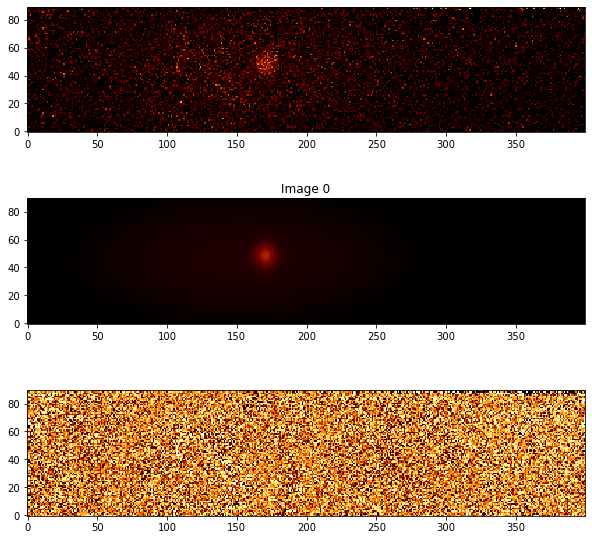

1


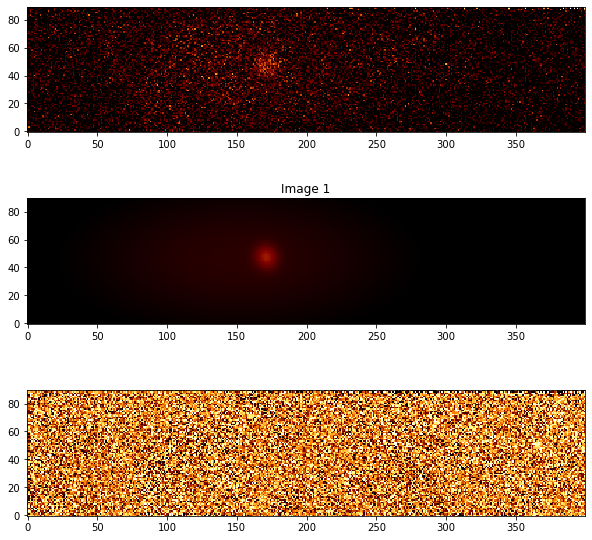

2


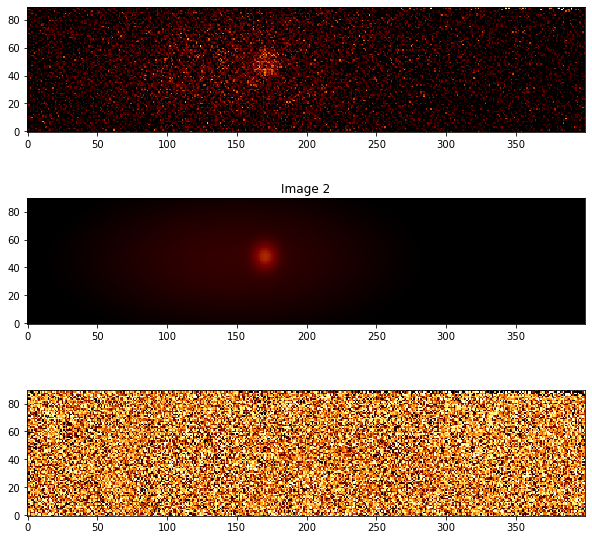

3


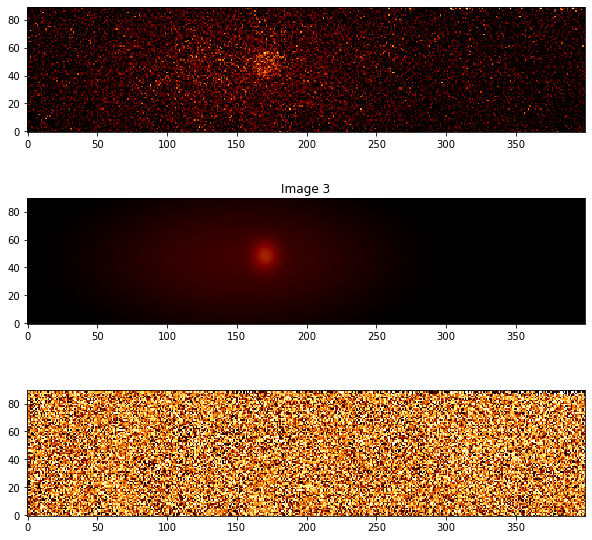

4


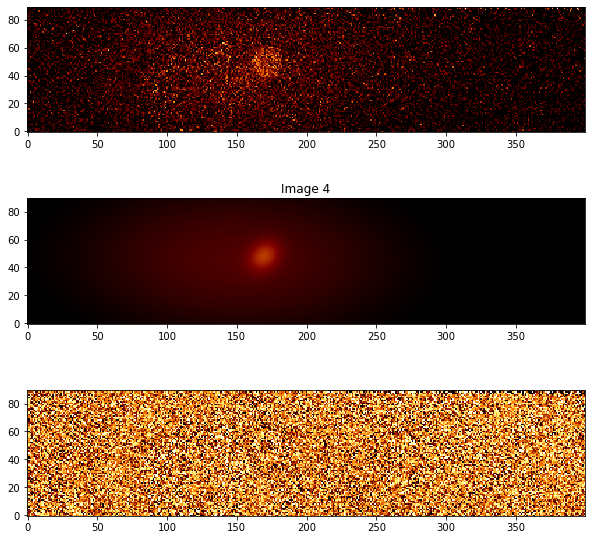

5


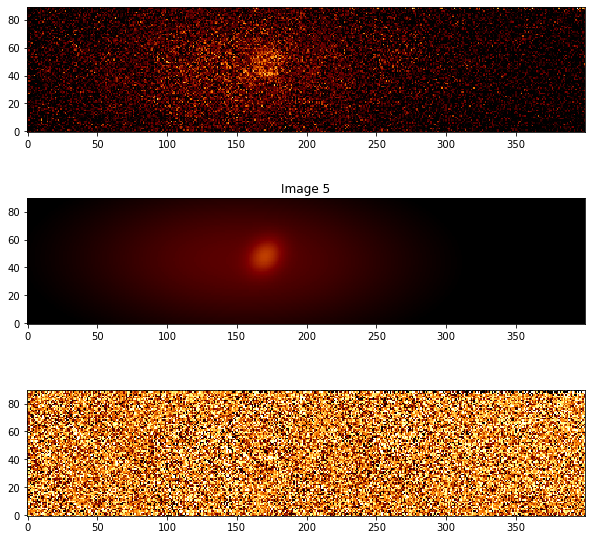

6


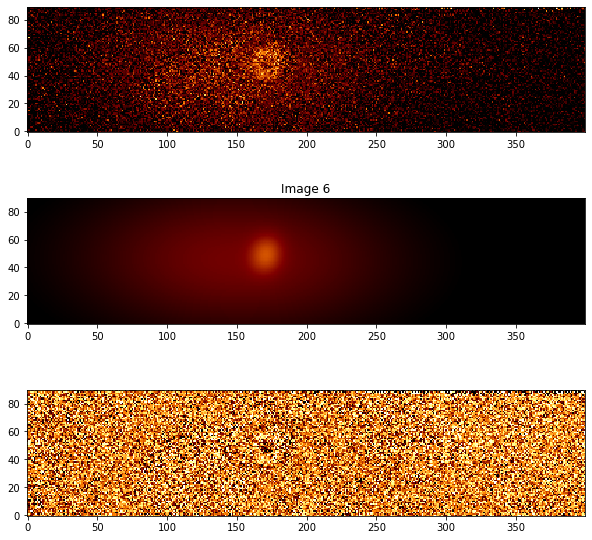

7


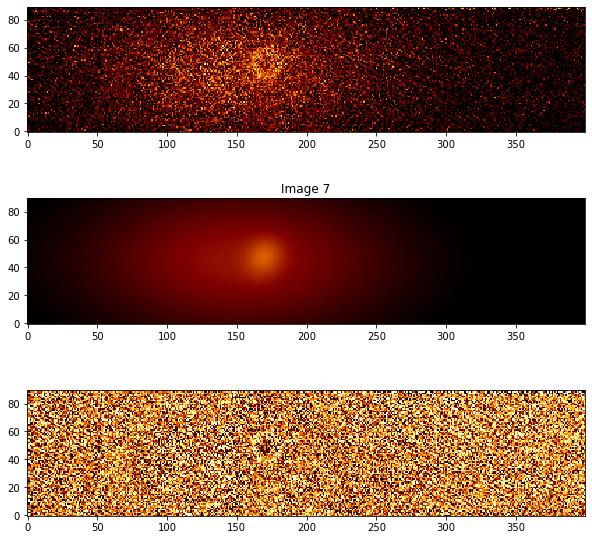

8


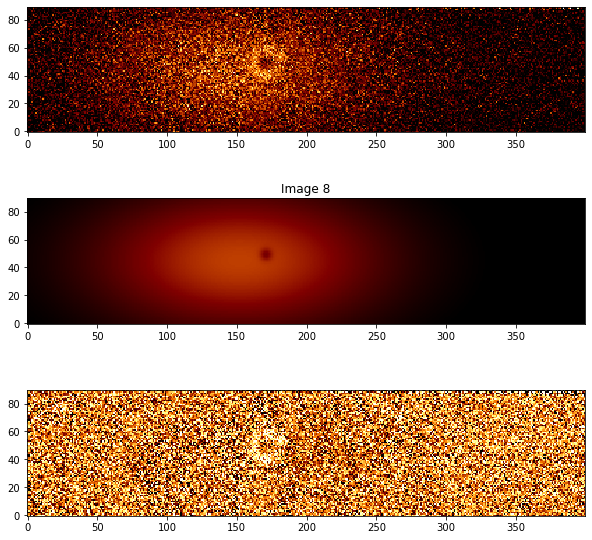

9


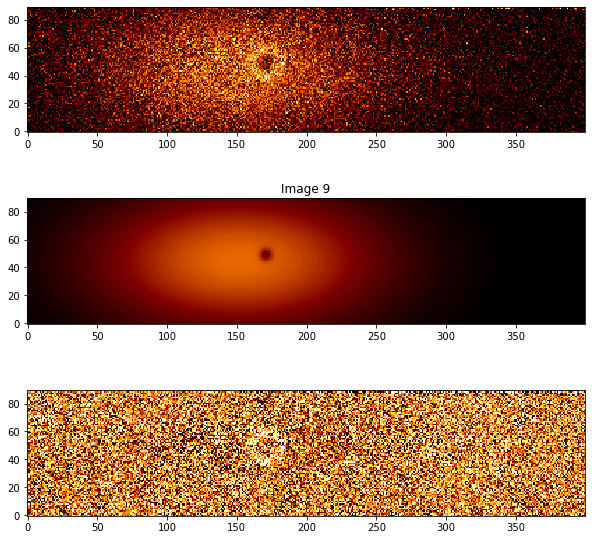

10


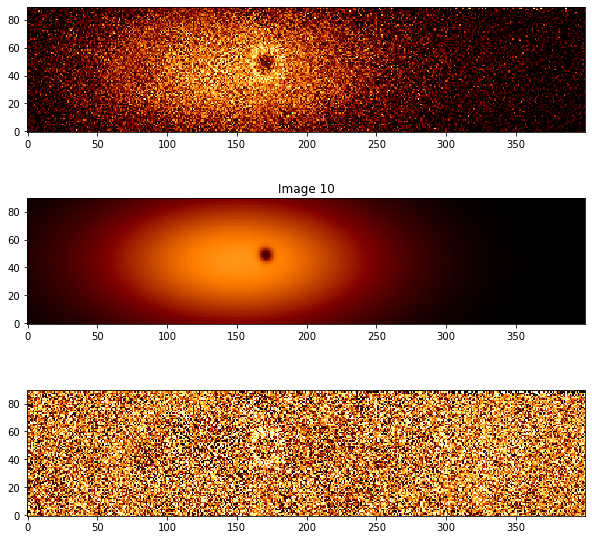

11


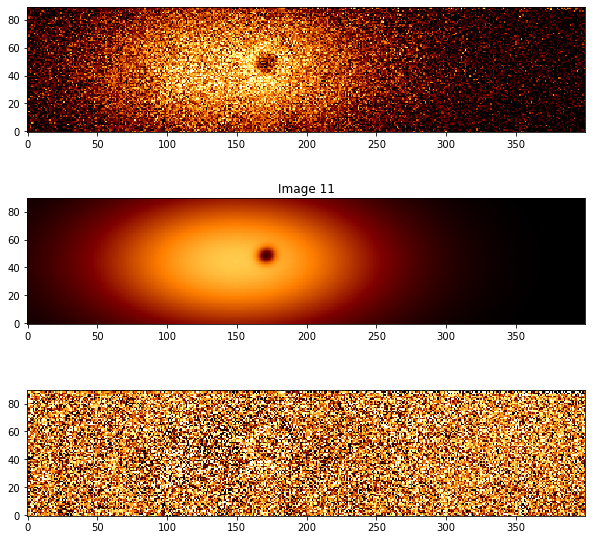

12


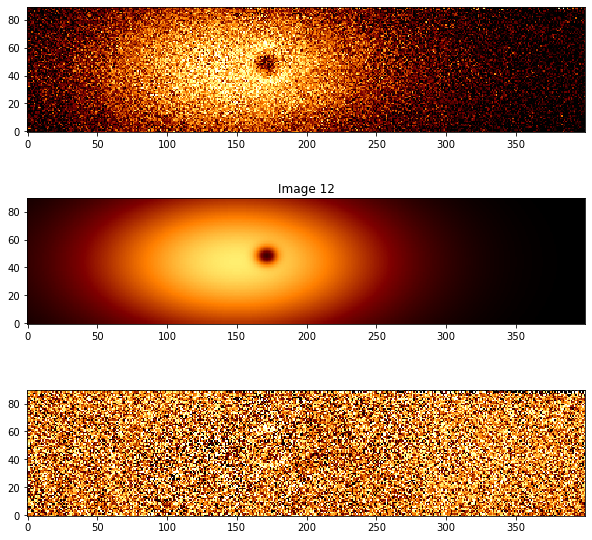

13


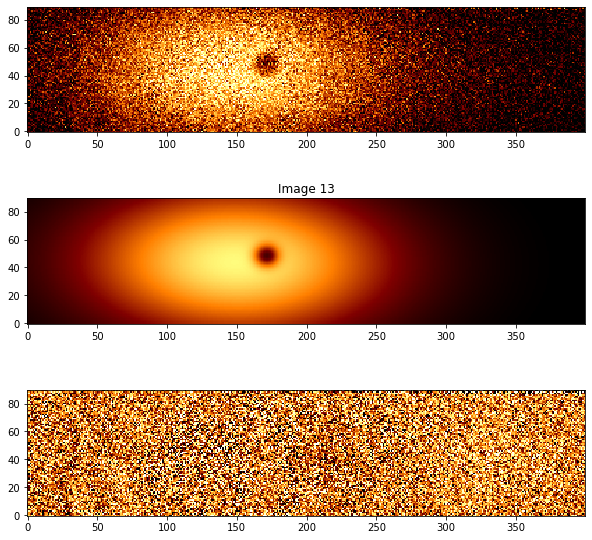

14


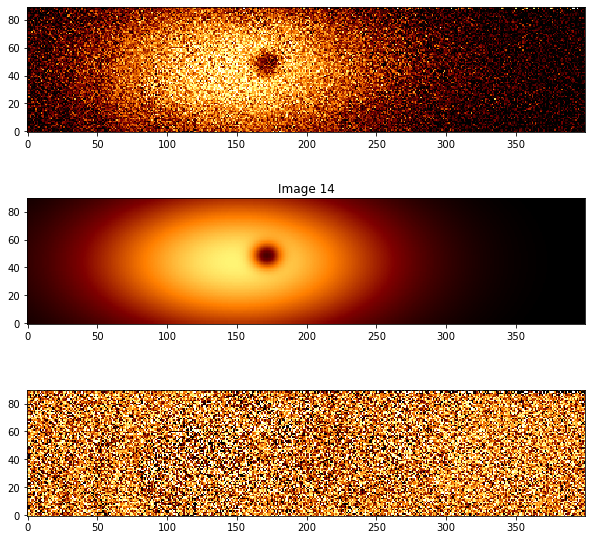

15


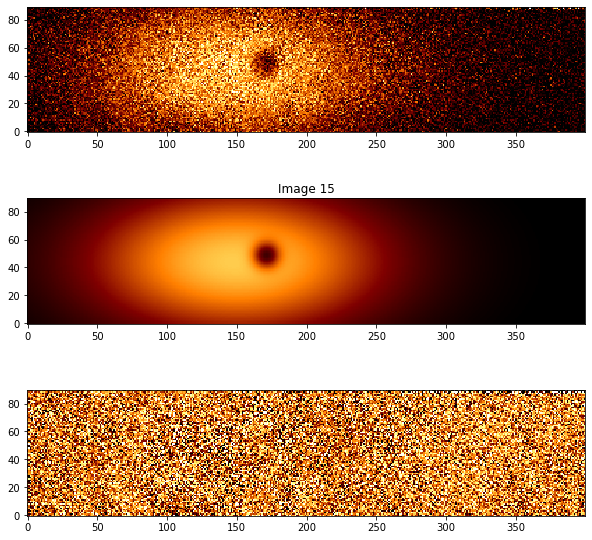

16


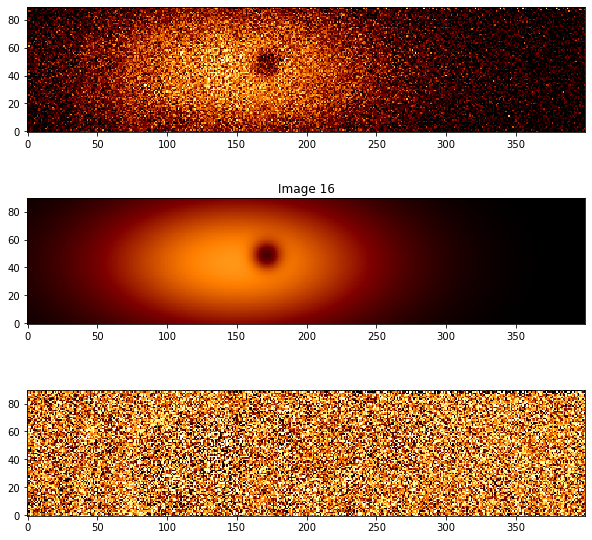

17


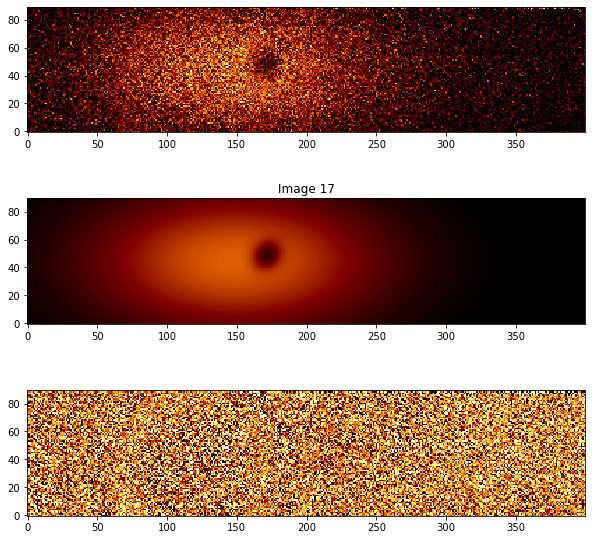

18


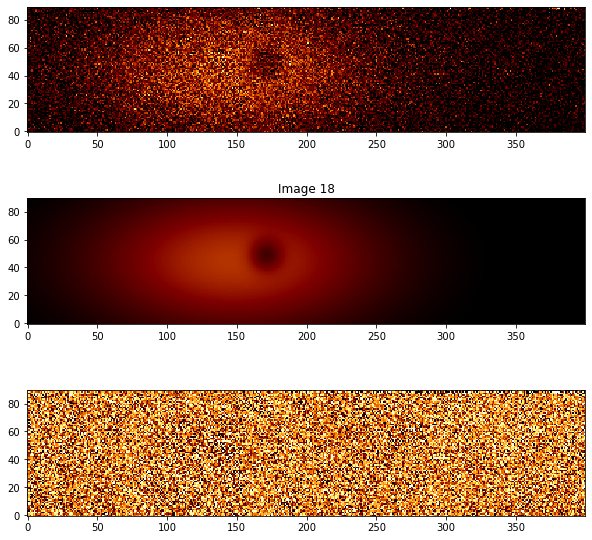

19


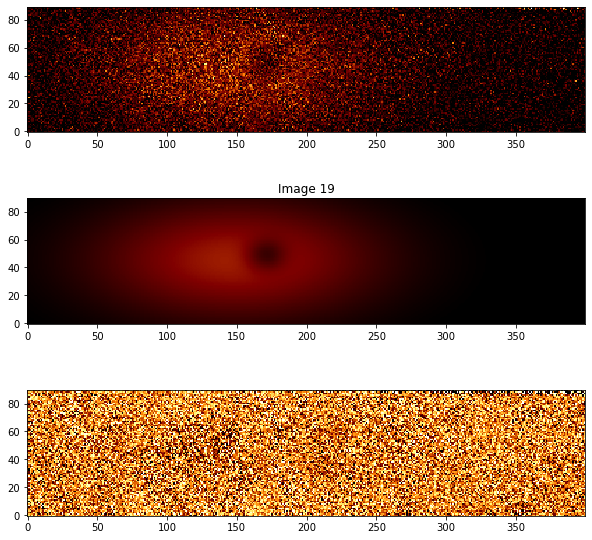

20


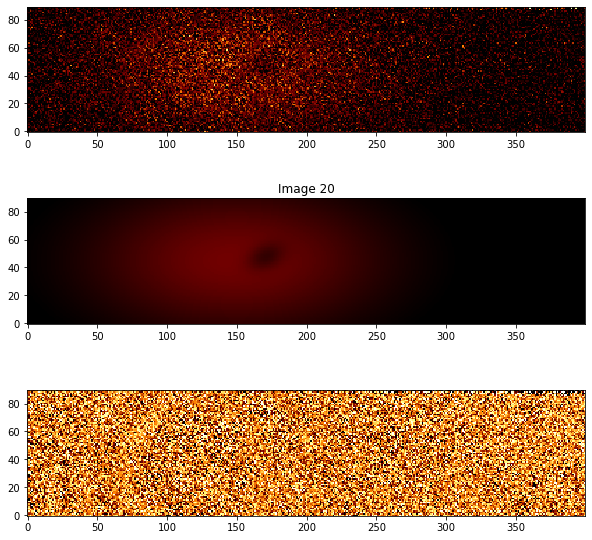

21


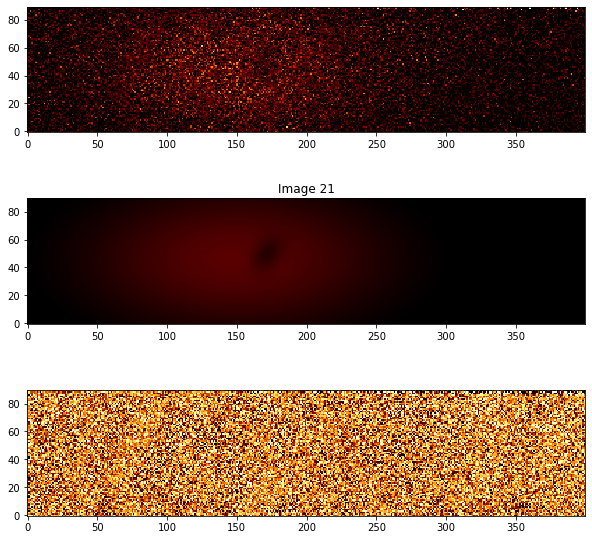

22


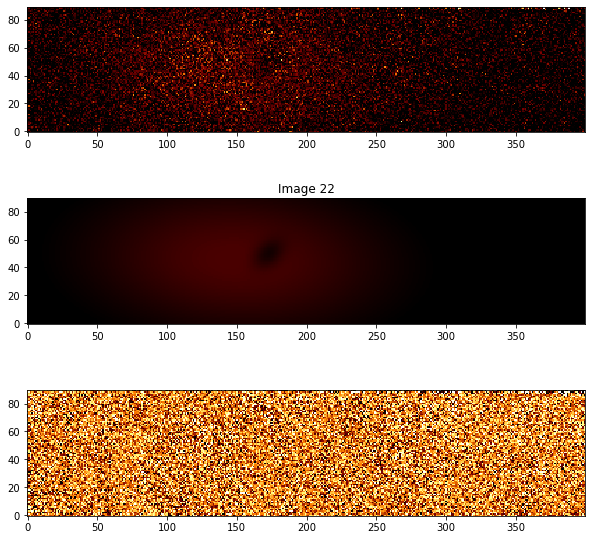

23


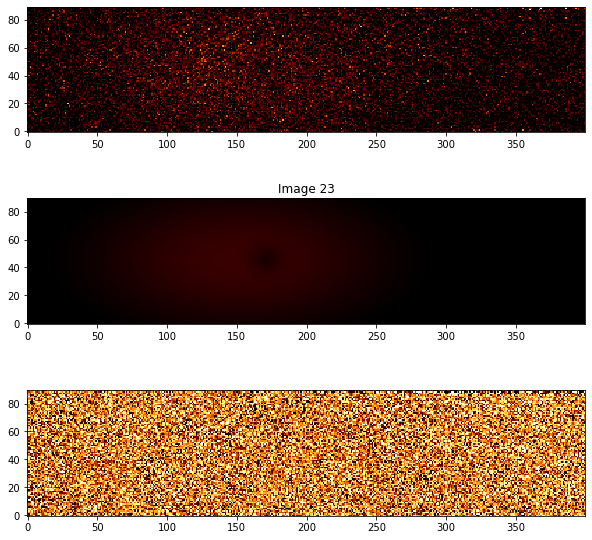

24


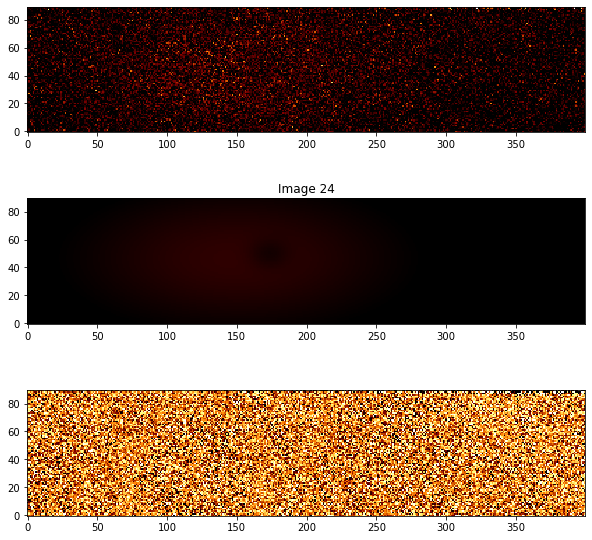

25


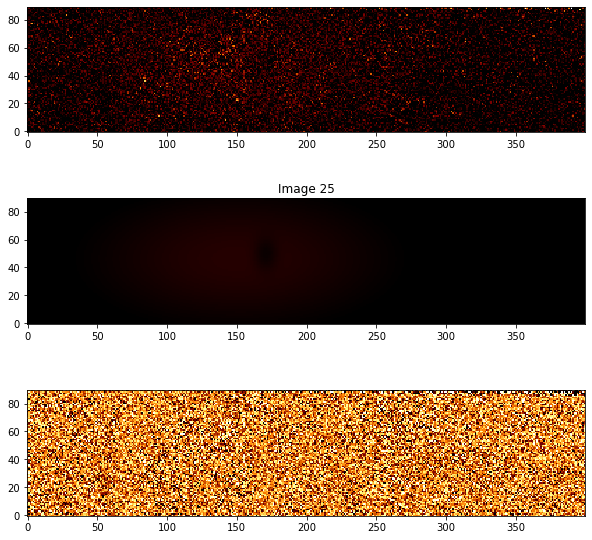

In [7]:
results=list()
for n in range(0,len(variables)):
    print(n)
    image = fitsopen(n)
    shape = image.shape
    x,y = np.mgrid[0:shape[0],0:shape[1]]
    image_flat=image.flatten()    
    out = model_twoG.fit(image_flat,params,xy_mesh=(x,y))##method='Powel')
    fig,ax = plt.subplots(3,1,figsize=(10,10))
    results.append(out)
    #params = out.params
    ax[0].imshow(image,
                 origin='bottom',vmin=0, vmax=0.8)
    ax[1].set_title('Image '+str(n))
    ax[1].imshow(out.best_fit.reshape(shape),
                 origin='bottom',vmin=0, vmax=0.8)
    ax[2].imshow((image-out.best_fit.reshape(shape)),
                 origin='bottom',vmin=-0.2, vmax=0.2)
    plt.show()

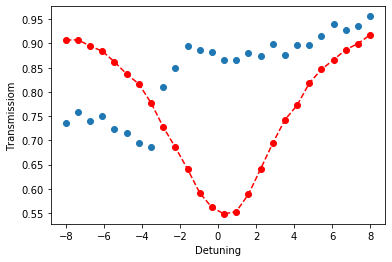

In [8]:
y = [np.e**(-r.params['amplitude2'].value - r.params['amplitude1'].value) for r in results],

yred = [np.e**(- r.params['amplitude1'].value) for r in results],



#yerr = np.sqrt([ (r.params['amplitude2'].stderr/r.params['amplitude2'].value)**2+(r.params['amplitude1'].stderr/r.params['amplitude1'].value)**2 if (r.params['amplitude2'].stderr is not None) & (r.params['amplitude2'].stderr is not None) else 0 for r in results ])

yerr = np.sqrt([ (r.params['amplitude2'].stderr)**2+(r.params['amplitude1'].stderr)**2 + (r.params['offset'].stderr)**2 
        if (r.params['amplitude2'].stderr is not None) & (r.params['amplitude2'].stderr is not None) & (r.params['offset'].stderr is not None) 
                else 0 for r in results ])

#yerr=np.array(yerr)*y
#plt.errorbar(variables,y,yerr=yerr,marker='o',linestyle='-')
#plt.plot(variables,cen_amp)
#out = model_AT.fit(y,params=params,Dp=variables )

#params = model_twoG.make_params()
#popt1, pcov1 = opt.curve_fit(lorentz,variables,y, p0=(2.5,1.,-0.13,0.1))

#plt.plot(variables,lorentz(np.array(variables), *popt1))
#v = np.linspace(min(variables),max(variables),200)
#plt.plot(variables,out.init_fit)
#plt.plot(v,model_AT.eval(out.params,Dp=v))
plt.plot(variables,y[0],marker='o',linestyle='')
plt.plot(variables,yred[0],marker='o',linestyle='--',color="red")
plt.xlabel("Detuning")
plt.ylabel("Transmissiom")
plt.savefig("eit.svg")
plt.show()
#n = np.argmax(-np.array(valdiv))

In [25]:
y = [r.params['sigma_x2'].value for r in results]

yerr = [r.params['sigma_x2'].stderr  if (r.params['amplitude2'].stderr is not None) else 0 for r in results]

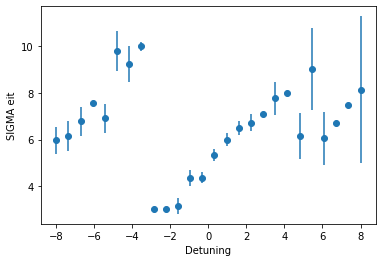

In [26]:
#yerr=np.array(yerr)*y
#plt.errorbar(variables,y,yerr=yerr,marker='o',linestyle='-')
#plt.plot(variables,cen_amp)
#out = model_AT.fit(y,params=params,Dp=variables )

#params = model_twoG.make_params()
#popt1, pcov1 = opt.curve_fit(lorentz,variables,y, p0=(2.5,1.,-0.13,0.1))

#plt.plot(variables,lorentz(np.array(variables), *popt1))
#v = np.linspace(min(variables),max(variables),200)
#plt.plot(variables,out.init_fit)
#plt.plot(v,model_AT.eval(out.params,Dp=v))
plt.errorbar(variables,y,yerr=yerr,marker='o',linestyle='')

plt.xlabel("Detuning")
plt.ylabel("SIGMA eit")
plt.savefig("waist-eit.svg")
plt.show()
#n = np.argmax(-np.array(valdiv))

In [9]:
results[2]

C:\Users\Control_Computer\AppData\Local\conda\conda\envs\rydlab\lib\site-packages\lmfit\printfuncs.py:287: RuntimeWarning:

divide by zero encountered in double_scalars



In [ ]:
yerr
out.result

y = [ r.redchi for r in results]

plt.plot(variables,y,marker='o',linestyle='')

#y = [ r. for r in results]

#plt.plot(variables,y,marker='o',linestyle='') 

In [76]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

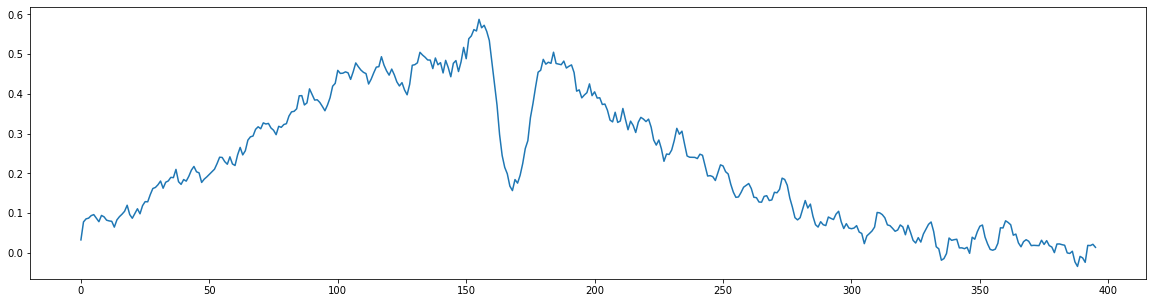

In [97]:
image = fitsopen(11)

slice = image[46:51]

slice_av=slice.mean(axis=0)
slice_av= running_mean(slice_av,5)
fig = plt.figure(figsize=(20,5))
#plt.imshow(slice,)

plt.plot(slice_av)